---

## Ejercicio 6: Caso Práctico Integrador

### Contexto

Una empresa de retail desea segmentar a sus clientes para personalizar sus estrategias de marketing. Dispone de datos de transacciones que incluyen información sobre el comportamiento de compra de cada cliente.

### Datos

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Scikit-learn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Configuración completada.")

Configuración completada.


In [195]:
# Simulación de datos de clientes
np.random.seed(RANDOM_STATE)
n_clientes = 800

# Generar características de clientes
data = {
    'CustomerID': range(1, n_clientes + 1),
    'Recency': np.concatenate([
        np.random.exponential(15, 200),      # Clientes muy activos
        np.random.exponential(45, 250),      # Clientes regulares
        np.random.exponential(90, 200),      # Clientes ocasionales
        np.random.exponential(180, 150)      # Clientes inactivos
    ]),
    'Frequency': np.concatenate([
        np.random.poisson(20, 200) + 5,
        np.random.poisson(8, 250) + 2,
        np.random.poisson(3, 200) + 1,
        np.random.poisson(1, 150) + 1
    ]),
    'Monetary': np.concatenate([
        np.random.lognormal(6, 0.5, 200),
        np.random.lognormal(5, 0.4, 250),
        np.random.lognormal(4.5, 0.6, 200),
        np.random.lognormal(4, 0.5, 150)
    ]),
    'AvgBasketSize': np.concatenate([
        np.random.normal(8, 2, 200),
        np.random.normal(5, 1.5, 250),
        np.random.normal(3, 1, 200),
        np.random.normal(2, 0.8, 150)
    ])
}

df=pd.DataFrame(data)
df.head(5)

,CustomerID,Recency,Frequency,Monetary,AvgBasketSize
0,1,7.039021,28,245.923646,9.103772
1,2,45.151821,26,396.428697,9.360460
2,3,19.751185,24,268.943029,4.126495
3,4,13.694138,33,231.129180,6.477289
4,5,2.544373,24,459.128705,6.243473


In [196]:
df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AvgBasketSize'], dtype='str')

In [197]:
df.describe().T.loc[['CustomerID','Frequency','Frequency','Monetary','Recency']]

,count,mean,std,min,25%,50%,75%,max
CustomerID,800.0,400.500000,231.084400,1.000000,200.750000,400.500000,600.250000,800.000000
Frequency,800.0,10.700000,9.312406,1.000000,3.000000,7.500000,16.000000,38.000000
Frequency,800.0,10.700000,9.312406,1.000000,3.000000,7.500000,16.000000,38.000000
Monetary,800.0,194.440113,192.562508,14.811747,71.873876,130.102305,244.804163,2041.717174
Recency,800.0,74.086882,107.378331,0.083061,11.503254,35.104613,87.124456,828.216236


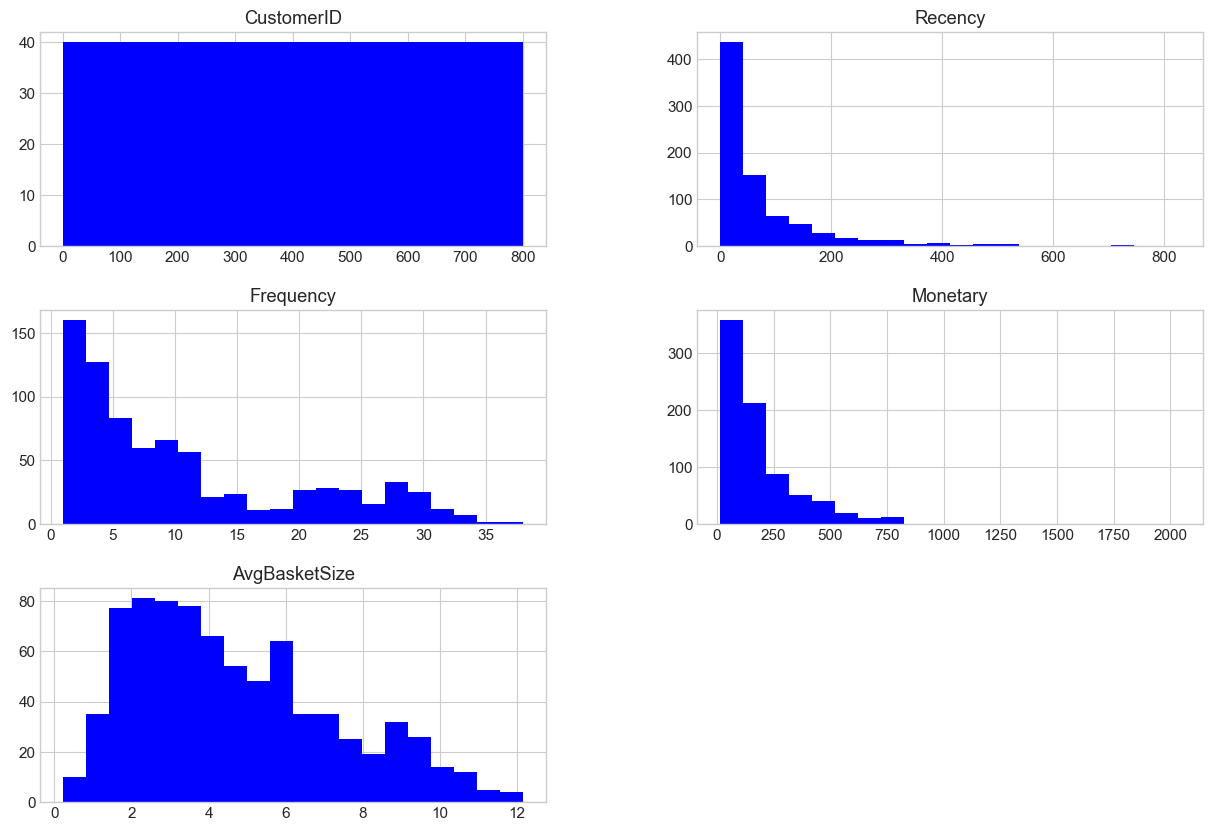

In [198]:
plt.Figure(figsize=(15,20))
df.hist(bins=20, figsize=(15,10), color="blue")
plt.show()

In [199]:
#Evaluamos si existen valores faltantes en cada columna
valores_faltantes_col={}
for i in df.columns:
    print(f"analizando columna {i}")
    valores_faltantes_col[i]=df[i].isna().sum()
print("analisis concluido")
for i, x in valores_faltantes_col.items():
    print("=="*80)
    print(f"columna {i} tiene {x} valores faltantes")

analizando columna CustomerID
analizando columna Recency
analizando columna Frequency
analizando columna Monetary
analizando columna AvgBasketSize
analisis concluido
columna CustomerID tiene 0 valores faltantes
columna Recency tiene 0 valores faltantes
columna Frequency tiene 0 valores faltantes
columna Monetary tiene 0 valores faltantes
columna AvgBasketSize tiene 0 valores faltantes


In [200]:
df.isna().sum().sum()

np.int64(0)

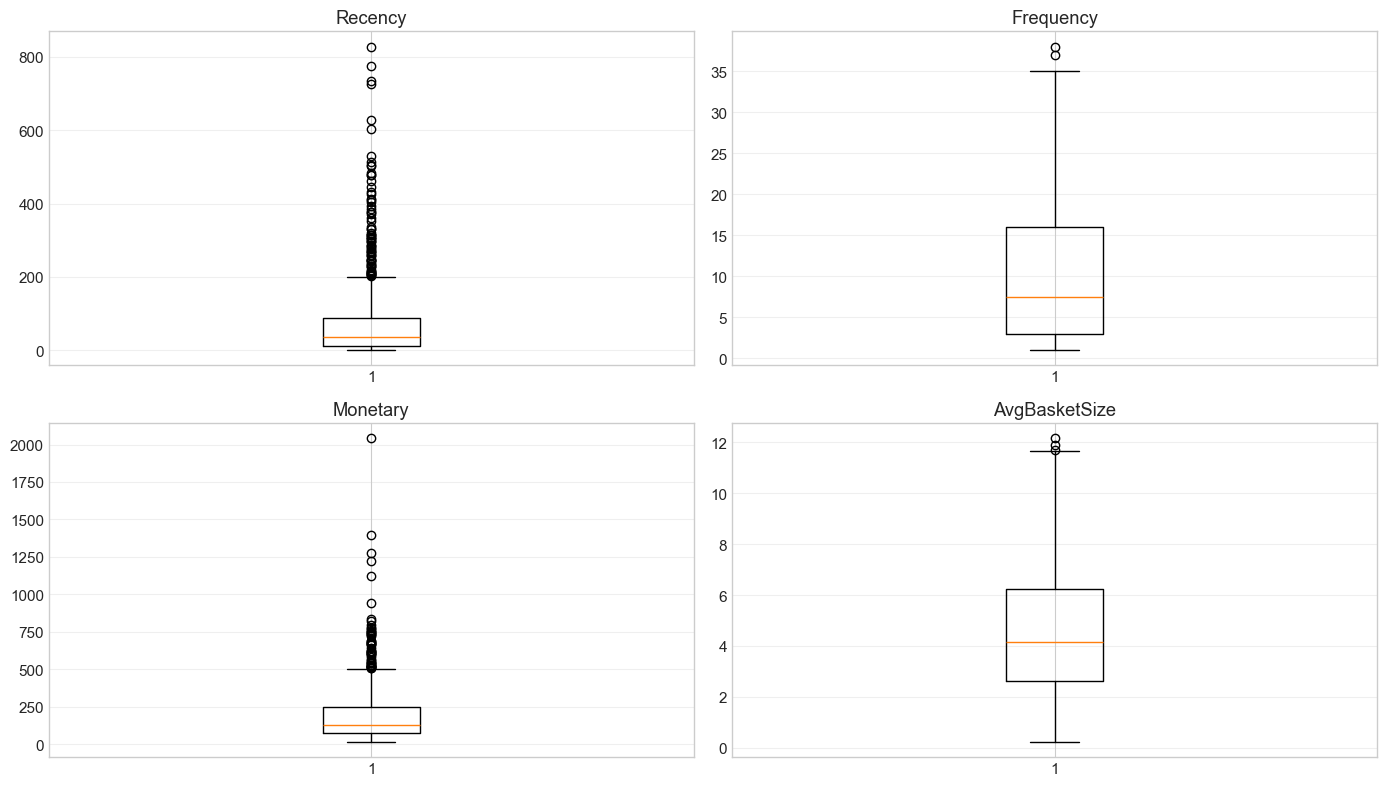

In [201]:
## analisis de outliers
#plt.boxplot(df)
import matplotlib.pyplot as plt

numerical_cols = (
    df.select_dtypes(include="number")
      .columns
      .drop("CustomerID", errors="ignore")
      .tolist()
)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes = axes.flatten()  # para iterar fácil

for ax, col in zip(axes, numerical_cols):
    ax.boxplot(df[col], vert=True)
    ax.set_title(col)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [202]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class IQRWinsorizerDF(BaseEstimator, TransformerMixin):
    """
    Winsoriza por IQR y devuelve SIEMPRE pandas.DataFrame con mismas columnas.
    No modifica la columna id_col (por defecto CustomerID).
    """
    def __init__(self, cols=None, k=1.5, id_col="CustomerID"):
        self.cols = cols
        self.k = k
        self.id_col = id_col

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("IQRWinsorizerDF espera un pandas.DataFrame como input.")

        self.feature_names_in_ = X.columns.to_numpy(dtype=object)

        if self.cols is None:
            self.cols_ = (
                X.select_dtypes(include="number")
                 .drop(columns=[self.id_col], errors="ignore")
                 .columns
                 .tolist()
            )
        else:
            self.cols_ = [c for c in list(self.cols) if c != self.id_col]

        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

        for c in self.cols_:
            s = pd.to_numeric(X[c], errors="coerce")
            q1 = np.nanpercentile(s, 25)
            q3 = np.nanpercentile(s, 75)
            iqr = q3 - q1

            if np.isnan(iqr) or iqr == 0:
                self.lower_bounds_[c] = -np.inf
                self.upper_bounds_[c] =  np.inf
            else:
                self.lower_bounds_[c] = q1 - self.k * iqr
                self.upper_bounds_[c] = q3 + self.k * iqr

        return self

    def transform(self, X):
        check_is_fitted(self, ["cols_", "lower_bounds_", "upper_bounds_", "feature_names_in_"])

        if not isinstance(X, pd.DataFrame):
            raise TypeError("IQRWinsorizerDF espera un pandas.DataFrame como input.")

        X_out = X.copy()
        for c in self.cols_:
            X_out[c] = pd.to_numeric(X_out[c], errors="coerce").clip(
                lower=self.lower_bounds_[c],
                upper=self.upper_bounds_[c]
            )

        return X_out

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_ if input_features is None else np.array(input_features, dtype=object)

In [203]:
## Pipeline de preprocesado antes de generar un aprendizaje no supervisado
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipe=Pipeline(steps=[
    ("Winclip", IQRWinsorizerDF(k=1.5)),
    ("std" , StandardScaler())
])



In [204]:
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numerical_cols),
    ],
remainder="passthrough"   # 👈 NO botar columnas no transformadas
)



In [205]:
## Procedemos a hacer un pequeño pipeline de preprocesado antes de trabajar con KMEANS para este dataset de 4 variables
X=preprocess.fit_transform(df)
df_transf=pd.DataFrame(
    X,
    columns=preprocess.get_feature_names_out(),
    index=df.index
)
df_transf

,num__Recency,num__Frequency,num__Monetary,num__AvgBasketSize,remainder__CustomerID
0,-0.841570,1.862219,0.464532,1.693580,1.0
1,-0.241396,1.646996,1.524854,1.792178,2.0
2,-0.641387,1.431773,0.626706,-0.218275,3.0
3,-0.736769,2.400277,0.360304,0.684705,4.0
4,-0.912348,1.431773,1.966581,0.594892,5.0
...,...,...,...,...,...
795,2.205803,-0.828071,-0.932376,-0.665553,796.0
796,2.205803,-0.720460,-0.943605,-0.979810,797.0
797,1.407927,-0.935683,-0.774088,-0.777637,798.0
798,2.205803,-1.043295,-1.072854,-1.066439,799.0


In [206]:
df_transf=df_transf[['remainder__CustomerID','num__Recency', 'num__Frequency', 'num__Monetary', 'num__AvgBasketSize']]
df_transf.drop('remainder__CustomerID', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
num__Recency,800.0,1.776357e-16,1.000626,-0.951107,-0.771270,-0.399612,0.419559,2.205803
num__Frequency,800.0,0.000000e+00,1.000626,-1.043295,-0.828071,-0.343819,0.570880,2.669306
num__Monetary,800.0,3.552714e-17,1.000626,-1.163673,-0.761665,-0.351440,0.456645,2.284109
num__AvgBasketSize,800.0,-2.131628e-16,1.000626,-1.713083,-0.801695,-0.211741,0.594771,2.689469


array([[<Axes: title={'center': 'num__Recency'}>,
        <Axes: title={'center': 'num__Frequency'}>],
       [<Axes: title={'center': 'num__Monetary'}>,
        <Axes: title={'center': 'num__AvgBasketSize'}>]], dtype=object)

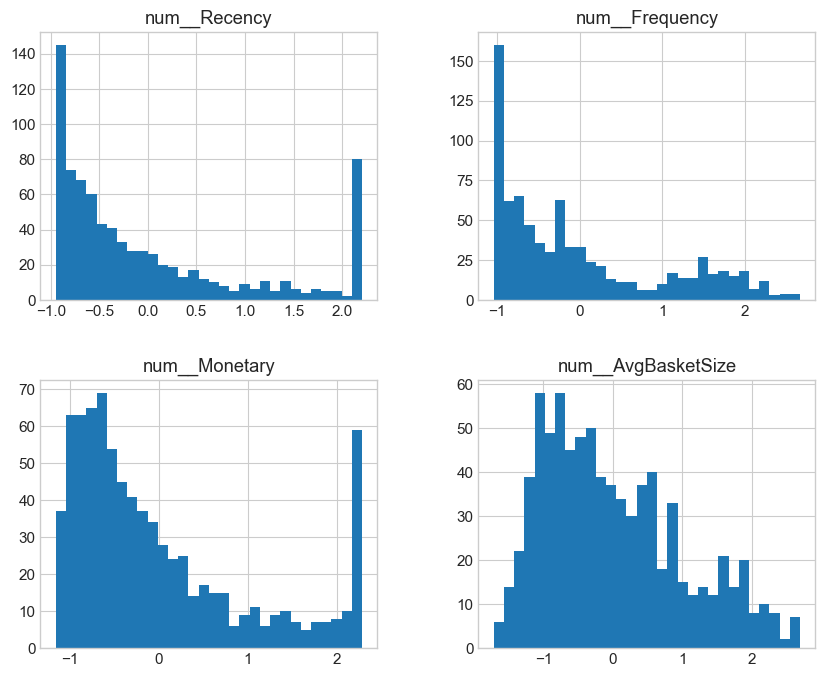

In [207]:
df_transf.drop('remainder__CustomerID', axis=1).hist(bins=30, figsize=(10,8))

In [208]:
X=df_transf.drop('remainder__CustomerID', axis=1)

c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Docume

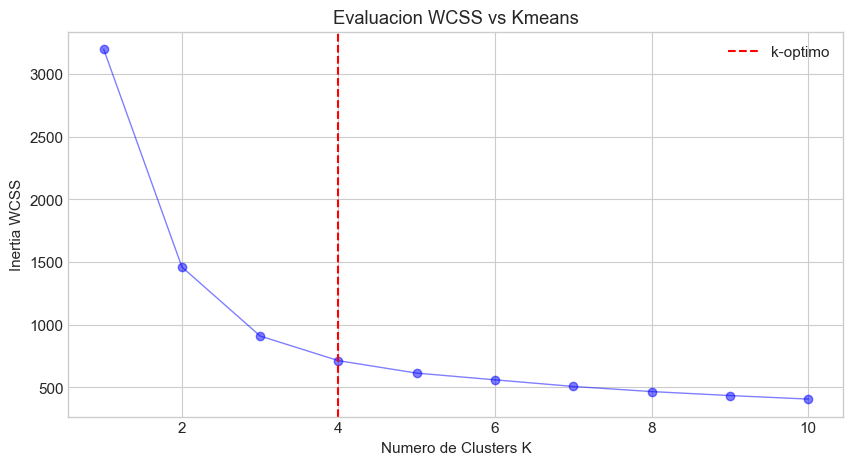

In [209]:
### Ahora que ya esta escalado el dataset procedemos a utilizar 

from sklearn.cluster import KMeans

k_pruebas=[1,2,3,4,5,6,7,8,9,10]
wccs=[]
centroides=[]

for k in k_pruebas:
    kmeans_model=KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans_model.fit(X)
    wccs.append(kmeans_model.inertia_)
    centroides.append(kmeans_model.cluster_centers_)

fig, ax=plt.subplots(figsize=(10,5))
ax.set_title("Evaluacion WCSS vs Kmeans")
ax.plot(k_pruebas, wccs, "go-", color="blue", alpha=0.5, linewidth=1)
ax.axvline(4, color="red", linestyle="--", linewidth=1.5, label="k-optimo")
ax.set_xlabel("Numero de Clusters K")
ax.set_ylabel("Inertia WCSS")
ax.legend()
plt.show()

Método de la Silueta (Silhouette Method)

El coeficiente de silueta mide la cohesión intra-cluster y la separación inter-cluster.

In [210]:
from sklearn.metrics import silhouette_score

k_prueba=range(2,10)
sil_score={}

for k in k_prueba:
    model=KMeans(
        n_clusters=k,
        init="k-means++",
        random_state=42,
        n_init=10,
        max_iter=300
    )
    model.fit(X)
    labels=model.predict(X)
    sil_score[k]=silhouette_score(X, labels)

k_list=[]
sil_score_list=[]
for k, sil in sil_score.items():
    print(f"con tantos clusters ({k}): el socre de silueta es igual a ({sil:.2f})")
    k_list.append(k)
    sil_score_list.append(sil)

c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Docume

con tantos clusters (2): el socre de silueta es igual a (0.50)
con tantos clusters (3): el socre de silueta es igual a (0.45)
con tantos clusters (4): el socre de silueta es igual a (0.38)
con tantos clusters (5): el socre de silueta es igual a (0.35)
con tantos clusters (6): el socre de silueta es igual a (0.35)
con tantos clusters (7): el socre de silueta es igual a (0.33)
con tantos clusters (8): el socre de silueta es igual a (0.30)
con tantos clusters (9): el socre de silueta es igual a (0.28)


c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


C:\Users\CHOPPE\AppData\Local\Temp\ipykernel_19208\3074244312.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(k_list, sil_score_list, "go-", color="green", linewidth=1.5,)


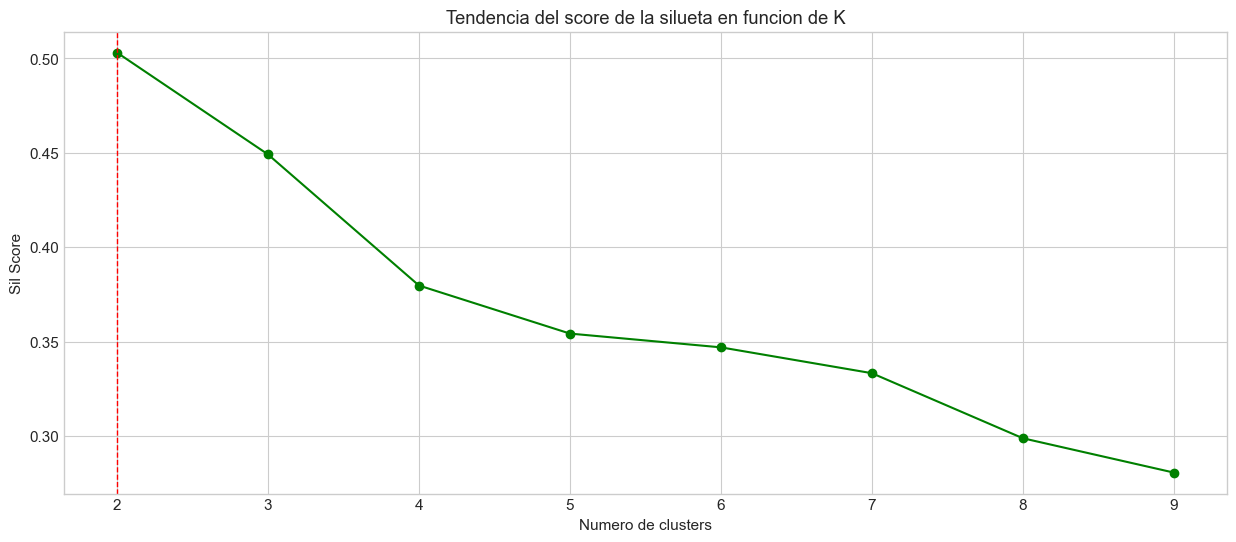

In [211]:
#Procedemos a plotear 

fig, ax=plt.subplots(figsize=(15,6))

ax.plot(k_list, sil_score_list, "go-", color="green", linewidth=1.5,)
ax.axvline(2, color="red", linestyle="--", linewidth=1)
ax.set_title("Tendencia del score de la silueta en funcion de K")
ax.set_xlabel("Numero de clusters")
ax.set_ylabel("Sil Score")
plt.show()

c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\CHOPPE\Docume

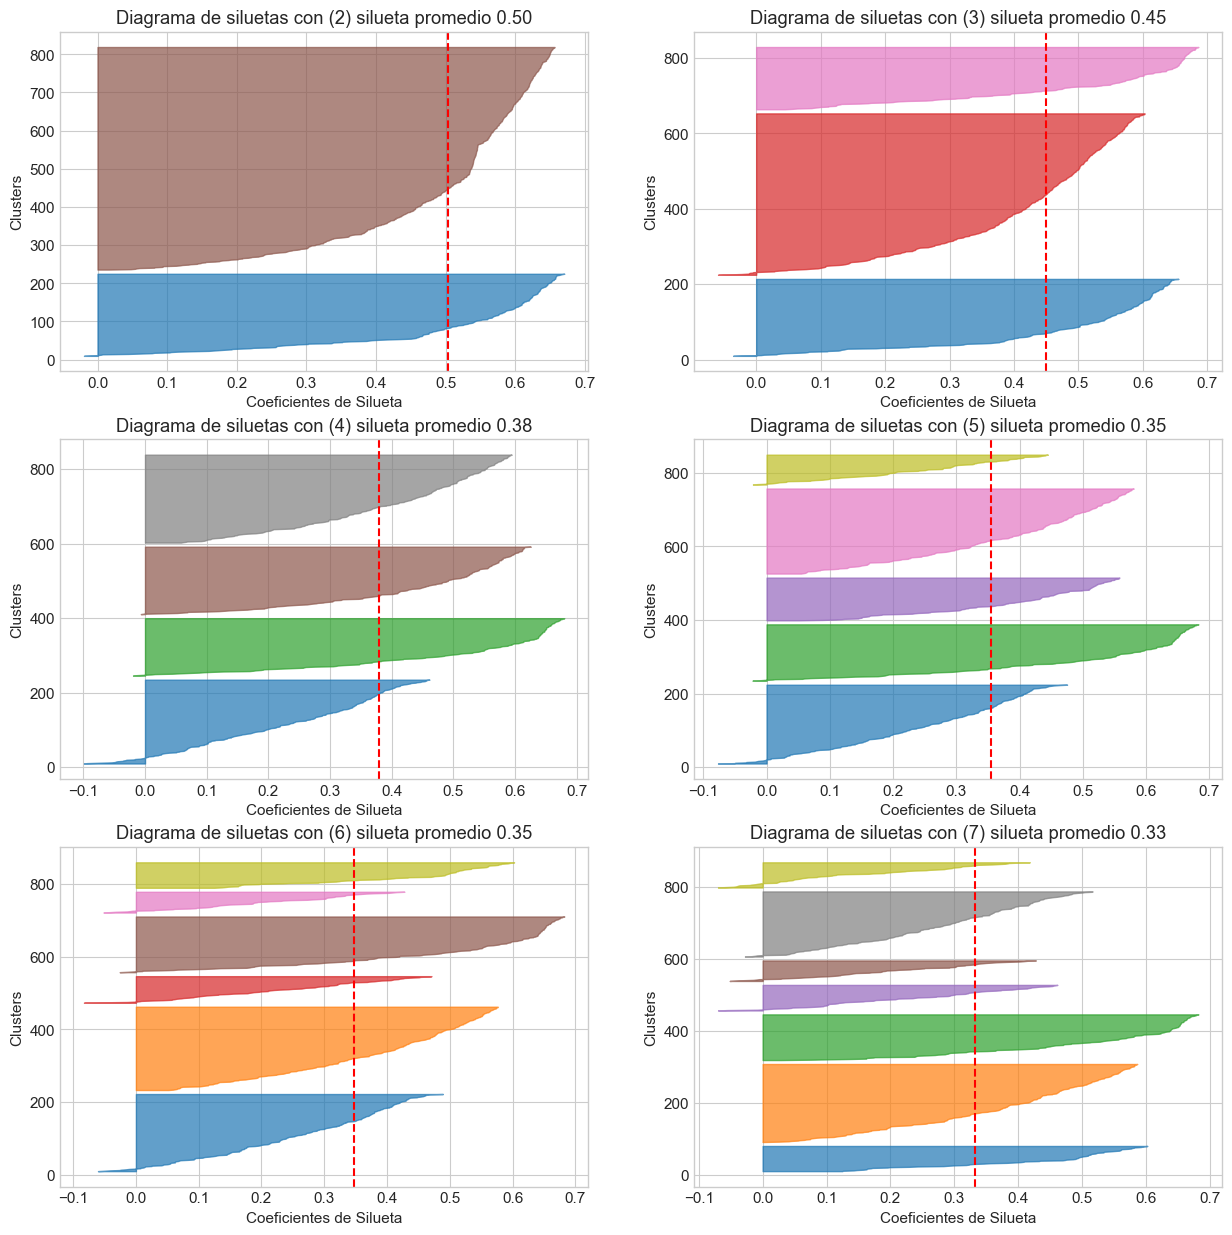

In [212]:
# Análisis de diagramas de silueta para k = 3, 4, 5, 6
#Entonces vamos a calcular el siluete sample de cada punto con respecto a su cluster es decir dentro de cada iteracion K tenemos que generar una iteracion para calcular el valor de silueta 

fig, axes=plt.subplots(3,2, figsize=(15,15))
axes=axes.flatten()

for idx, k in enumerate([2,3,4,5,6,7]):
    ax=axes[idx] #Definimos eje de ploteo, iniciando en 0 y concluyendo en 3

    model=KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=RANDOM_STATE)
    model.fit(X)
    cluster_labels=model.predict(X)

    avg_sil_score=silhouette_score(X, cluster_labels)
    sil_vals=silhouette_samples(X, cluster_labels)
    
    ##Visualizar diagrama
    y_lower=10

    for i in range (k):
        cluster_sil_vals=sil_vals[cluster_labels==i] ##Mascara para calcular score segun su cluster
        cluster_sil_vals.sort()
        cluster_size=cluster_sil_vals.shape[0]
        y_upper=y_lower+cluster_size
        color=plt.cm.tab10(i/k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),    
                        0,
                        cluster_sil_vals, color=color,alpha=0.7) ##Definir espacio visual para graficar 
        y_lower=y_upper+10
    ax.axvline(avg_sil_score, linestyle="--", color="red")
    ax.set_title(f"Diagrama de siluetas con ({k}) silueta promedio {avg_sil_score:.2f}")
    ax.set_xlabel("Coeficientes de Silueta")
    ax.set_ylabel("Clusters")




### Tarea 6.4: Segmentación y Perfilado

Aplique K-Means con el número de clusters seleccionado y genere perfiles descriptivos de cada segmento.

In [213]:
X=X.rename(columns={
    'num__Recency':"Recency", 
    'num__Frequency':"Frequency", 
    'num__Monetary':"Monetary", 
    'num__AvgBasketSize':"AvgBasketSize",
    'segmento':"Segmento"
})

In [214]:
X

,Recency,Frequency,Monetary,AvgBasketSize
0,-0.841570,1.862219,0.464532,1.693580
1,-0.241396,1.646996,1.524854,1.792178
2,-0.641387,1.431773,0.626706,-0.218275
3,-0.736769,2.400277,0.360304,0.684705
4,-0.912348,1.431773,1.966581,0.594892
...,...,...,...,...
795,2.205803,-0.828071,-0.932376,-0.665553
796,2.205803,-0.720460,-0.943605,-0.979810
797,1.407927,-0.935683,-0.774088,-0.777637
798,2.205803,-1.043295,-1.072854,-1.066439


In [215]:
Features=['Recency', 'Frequency', 'Monetary', 'AvgBasketSize']

In [216]:
# TODO: Segmentación final
# 1. Ajustar KMeans con k óptimo
# 2. Asignar segmentos a los clientes
# 3. Calcular estadísticas por segmento

K_OPTIMO = 4
# 1. Ajustar modelo final
model_optimo=KMeans(n_clusters=4,
                    init="k-means++",
                    n_init=10,
                    max_iter=300,
                    random_state=RANDOM_STATE,
                    )
model_optimo.fit(X)
df["segmento"]=model_optimo.predict(X)

# 2. Distribución de clientes por segmento
print("=="*60)
print("RESULTADOS DE LA SEGMENTACIÓN")
print("=="*60)

print("distribución de clientes por segmento")
print(df["segmento"].value_counts().sort_index())

print("\nPorcentajes")
print(round(df["segmento"].value_counts(normalize=True).sort_index(),2)*100)

# 3. Estadísticas descriptivas por segmento
print("=="*60)
print("RESULTADOS  Estadísticas descriptivas por segmento")
print("=="*60)
df_seg_resumen=df.groupby("segmento")[Features].agg(["mean", "median","std"]).round(2)
print(df_seg_resumen.to_string())


# Tabla resumida con medias
print("=="*60)
print("PERFIL DE CADA SEGMENTO (PROMEDIOS)")
print("=="*60)
df_segmentos_mean=df.groupby("segmento")[Features].mean().round(2)
df_segmentos_mean["N_Clientes"]=df["segmento"].value_counts()
df_segmentos_mean["%_Clientes"]=round(df["segmento"].value_counts(normalize=True),2)*100
print(df_segmentos_mean.to_string())



# Centroides en escala original
print("\n" + "="*60)
print("CENTROIDES (escala estandarizada)")
print("="*60)

centroides_scaled=pd.DataFrame(model_optimo.cluster_centers_, columns=Features)
print(centroides_scaled.to_string())

# Transformar centroides a escala original
print("\n" + "="*60)
print("CENTROIDES (escala original")
print("="*60)
scaler=preprocess.named_transformers_["num"].named_steps["std"]
centroides_og=scaler.inverse_transform(model_optimo.cluster_centers_)
df_centroides_og=pd.DataFrame(centroides_og, columns=Features)
print(df_centroides_og.to_string())


# Métricas de calidad del clustering
print("\n" + "="*60)
print("MÉTRICAS DE CALIDAD")
print("="*60)
print(f"Inercia (WCSS): {model_optimo.inertia_:.2f}")
print(f"Coeficiente de Silueta: {silhouette_score(X, df['segmento']):.4f}")


RESULTADOS DE LA SEGMENTACIÓN
distribución de clientes por segmento
segmento
0    226
1    155
2    182
3    237
Name: count, dtype: int64

Porcentajes
segmento
0    28.0
1    19.0
2    23.0
3    30.0
Name: proportion, dtype: float64
RESULTADOS  Estadísticas descriptivas por segmento
         Recency                 Frequency              Monetary                 AvgBasketSize             
            mean  median     std      mean median   std     mean  median     std          mean median   std
segmento                                                                                                   
0          37.27   30.48   31.76     10.96   10.0  4.40   172.19  160.57   73.72          5.32   5.21  1.32
1         245.12  198.82  140.12      3.59    3.0  2.89    84.96   73.39   53.41          2.65   2.44  1.25
2          13.89    9.84   13.70     25.42   26.0  4.54   455.84  414.93  236.69          8.23   8.44  1.84
3          43.56   38.53   29.64      3.80    3.0  2.37    86.51   

c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [217]:
centroides_scaled = pd.DataFrame(model_optimo.cluster_centers_, columns=Features)
centroides_scaled

,Recency,Frequency,Monetary,AvgBasketSize
0,-0.365520,0.028060,-0.055511,0.240969
1,1.801778,-0.764199,-0.669470,-0.787293
2,-0.733635,1.582547,1.496606,1.357516
3,-0.266441,-0.742255,-0.658519,-0.757369


In [218]:
df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AvgBasketSize',
       'segmento'],
      dtype='str')

In [222]:
#Practicamos nuevamente como generar todos estos datos en una tabla

X_transf=preprocess.fit_transform(df.drop(["CustomerID",'segmento'], axis=1))
X_transf=pd.DataFrame(X_transf,
                      columns=['Recency', 'Frequency', 'Monetary', "AvgBasketSize"])
X_transf.head()

,Recency,Frequency,Monetary,AvgBasketSize
0,-0.841570,1.862219,0.464532,1.693580
1,-0.241396,1.646996,1.524854,1.792178
2,-0.641387,1.431773,0.626706,-0.218275
3,-0.736769,2.400277,0.360304,0.684705
4,-0.912348,1.431773,1.966581,0.594892


array([[<Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'Monetary'}>,
        <Axes: title={'center': 'AvgBasketSize'}>]], dtype=object)

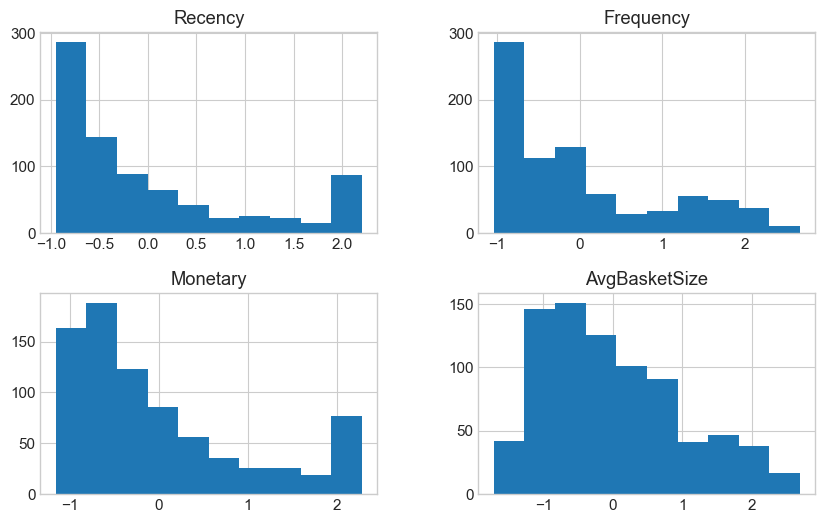

In [226]:
X_transf.hist()

In [245]:
## hacemos de caso que ya resolvimos por K-means y evaluamos con tecnica del codo y con sileta el valor ideal de K 
k=3
model_optimo=KMeans(n_clusters=3,
                    init="k-means++",
                    max_iter=300,
                    n_init=10,
                    random_state=42,
)
model_optimo.fit(X_transf)
cluster_labels=model_optimo.predict(X_transf)
val_sil_score=silhouette_score(X_transf, cluster_labels)

print("=="*80)
print("Segmentacion de clusters Numeros")
print("=="*80)

df["segmento"]=model_optimo.predict(X_transf)
print(df["segmento"].value_counts().sort_index().to_string())


print("=="*80)
print("Segmentacion de clusters porcentaje")
print("=="*80)
print((df["segmento"].value_counts(normalize=True).round(2)*100).sort_index())

print("=="*80)
print("Resumen perfiles por promedio")
print("=="*80)
df_perfiles_promedios=df.drop("CustomerID",axis=1).groupby("segmento").mean()
print(df_perfiles_cluster.round(2).to_string())

print("=="*80)
print("Resumen Estadistico perfiles")
print("=="*80)
df_perfiles_estadistico=df.drop("CustomerID",axis=1).groupby("segmento").agg(["mean", "std", "median"])
print(df_perfiles_estadistico.round(2).to_string())

Segmentacion de clusters Numeros
segmento
0    205
1    429
2    166
Segmentacion de clusters porcentaje
segmento
0    26.0
1    54.0
2    21.0
Name: proportion, dtype: float64
Resumen perfiles por promedio
          Recency  Frequency  Monetary  AvgBasketSize
segmento                                             
0           14.69      24.77    431.78           7.98
1           39.72       6.69    123.22           3.90
2          236.25       3.69     85.40           2.70
Resumen Estadistico perfiles
         Recency                 Frequency              Monetary                 AvgBasketSize             
            mean     std  median      mean   std median     mean     std  median          mean   std median
segmento                                                                                                   
0          14.69   14.88   10.48     24.77  4.99   25.0   431.78  235.79  390.59          7.98  1.99   8.14
1          39.72   29.08   35.20      6.69  4.06    6.0   123.

c:\Users\CHOPPE\Documents\CEROSA 2024\anaconda\envs\kmeans_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
